In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from beamline34IDC.simulation.facade import Implementors
from beamline34IDC.simulation.facade.focusing_optics_factory import focusing_optics_factory_method
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = 111

In [8]:
work_dir = '/Users/saugat/code/oasys/ML_Control_System/work_directory'
os.chdir(work_dir)
input_beam_path = "primary_optics_system_beam.dat"

In [6]:
fig_save_path = 'figures/opt_hkb_mot4_vkb_mot4/'

In [7]:
if not os.path.isdir(fig_save_path):
    print("Fig save directory does not exist. Trying to create.")
    os.mkdir(fig_save_path)

In [10]:
# Focusing Optics System -------------------------
focusing_system, out_beam = opt_common.reinitialize(input_beam_path)

In [11]:
move_motors = ['hkb_4', 'vkb_4']

motors ['hkb_4', 'vkb_4'] trans [0.0, 0.0] current loss 9.843931244883503e-05
0.00010336077532020267 (<beamline34IDC.simulation.shadow.focusing_optics.__FocusingOptics object at 0x7f8ad802eb00>, 9.843931244883503e-05)


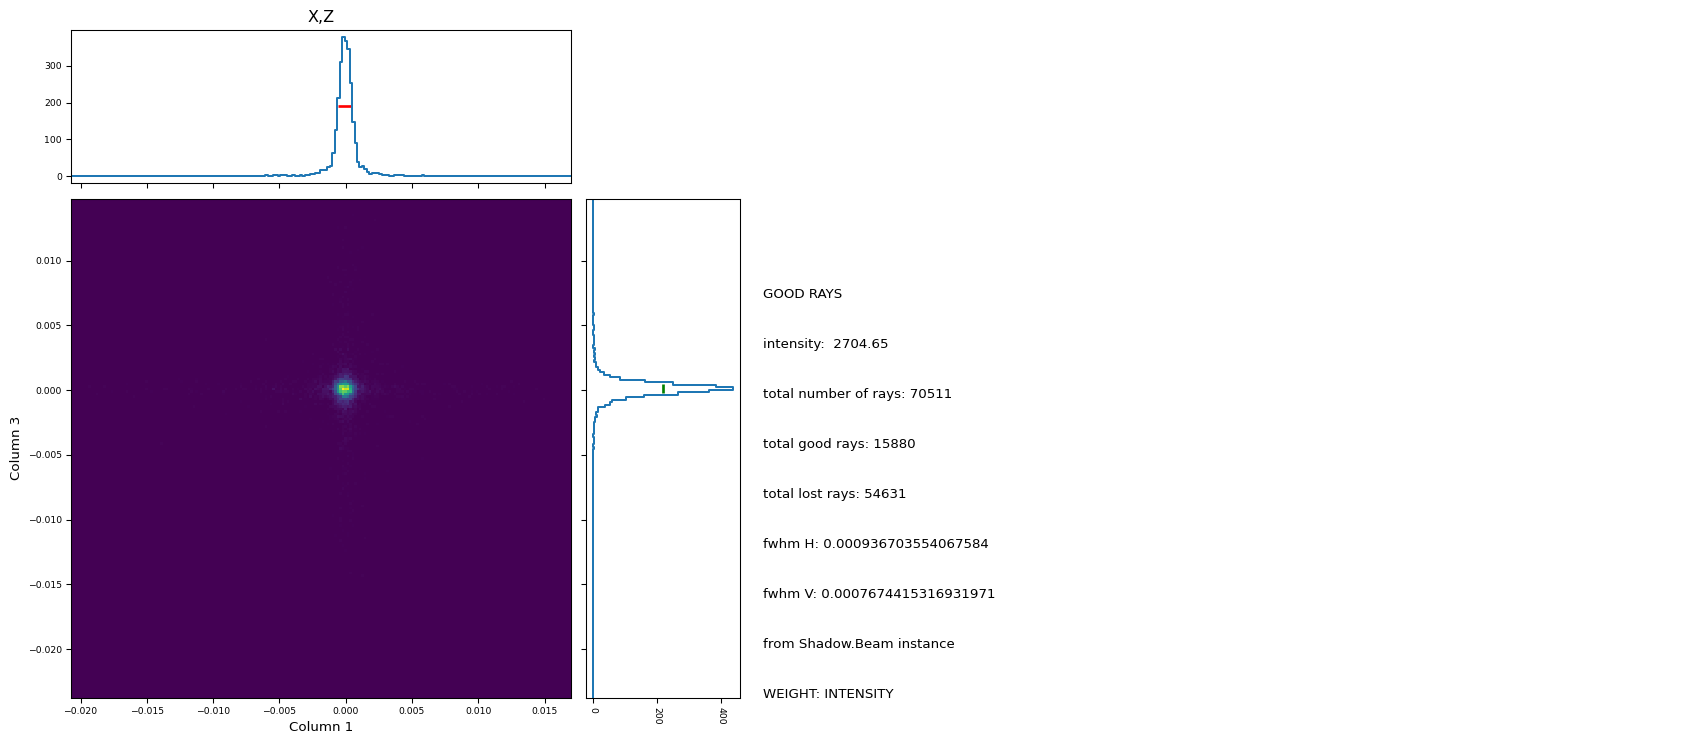

In [12]:
centroid, out_beam, hist, dw = opt_common.getCentroidDistance(focusing_system)
print(centroid, opt_common.lossFunction(focusing_system, move_motors, [0., 0.0]))
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [27]:
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

for outer in tqdm(range(2)):
    translations = np.random.uniform(-0.14, 0.14, size=2)
    focusing_system = opt_common.moveMotors(focusing_system, move_motors, translations, movement='absolute')
    centroid, out_beam, *_ = opt_common.getCentroidDistance(focusing_system)
    absolute_movements.append(translations)
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    focusing_system, guesses_all, success = opt_common.optimizationTrials(focusing_system, move_motors, translations, 
                                                               DEFAULT_RANDOM_SEED, 1, verbose=True)
    start_guesses.append(guesses_all)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.getCentroidDistance(focusing_system)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')
    

  0%|                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]

motors ['hkb_4', 'vkb_4'] trans [0. 0.] current loss 0.10591788842851389
Initial loss is 0.10591788842851389
[ 0.02436614 -0.01310697]
motors ['hkb_4', 'vkb_4'] trans [ 0.02436614 -0.01310697] current loss 0.0846767562923089
motors ['hkb_4', 'vkb_4'] trans [0.00121831 0.        ] current loss 0.08351534054145987
motors ['hkb_4', 'vkb_4'] trans [-0.00121831 -0.00065535] current loss 0.08487228764670417
motors ['hkb_4', 'vkb_4'] trans [0.00121831 0.0013107 ] current loss 0.0833209853880045
motors ['hkb_4', 'vkb_4'] trans [0.00060915 0.00065535] current loss 0.0825479131386449
motors ['hkb_4', 'vkb_4'] trans [0.00121831 0.        ] current loss 0.08138340997787415
motors ['hkb_4', 'vkb_4'] trans [0.00152288 0.00065535] current loss 0.07973682355031542
motors ['hkb_4', 'vkb_4'] trans [0.00060915 0.0013107 ] current loss 0.07878298187339586
motors ['hkb_4', 'vkb_4'] trans [0.00197975 0.00163837] current loss 0.0764586537215537
motors ['hkb_4', 'vkb_4'] trans [0.00274119 0.00065535] current 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:57<00:00, 237.83s/it]

Test 0 success True


In [29]:
print('Initial centroids are at', initial_dws[0].get_parameter('h_centroid'), initial_dws[0].get_parameter('v_centroid'))

Initial centroid is at 0.030164794661360746 -0.02692614897713015


In [30]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [31]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [32]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [33]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

In [37]:
list(zip(*absolute_movements))

[(-0.03024176596224183, -0.10545156258259164),
 (-0.02706195009768257, -0.012017297505226343)]

In [41]:
np.array(absolute_movements

[array([-0.03024177, -0.02706195]), array([-0.10545156, -0.0120173 ])]

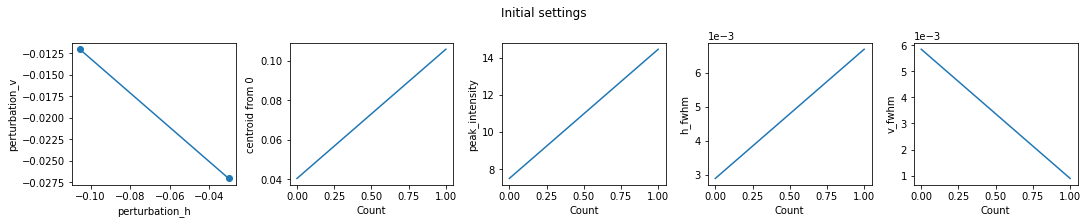

In [50]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(*zip(*absolute_movements), marker='o')
axes[0].set_ylabel('perturbation_v')
axes[0].set_xlabel('perturbation_h')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('centroid from 0')
axes[1].set_xlabel('Count')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')
axes[2].set_xlabel('Count')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))
axes[3].set_xlabel('Count')


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))
axes[4].set_xlabel('Count')

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/hkb_4_vkb_4_initial_metrics.png', bbox_inches='tight')

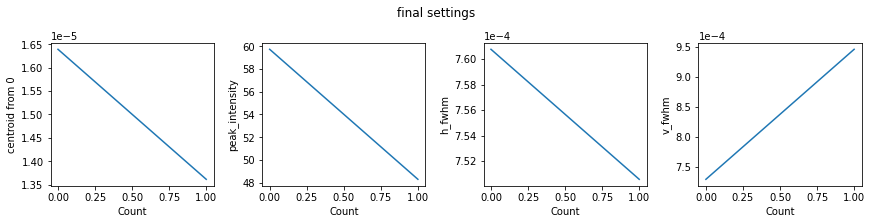

In [51]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('centroid from 0')
axes[0].set_xlabel('Count')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')
axes[1].set_xlabel('Count')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))
axes[2].set_xlabel('Count')


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))
axes[3].set_xlabel('Count')

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/hkb_4_vkb_4_final_metrics.png', bbox_inches='tight')

/Applications/Oasys1.2.app/Contents/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


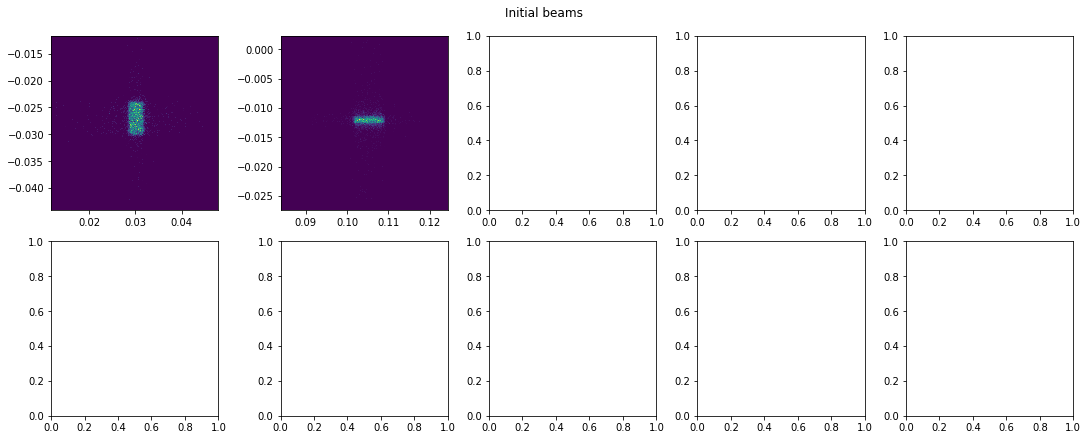

In [52]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/hkb_4_vkb_4_initial_beams.png', bbox_inches='tight')

/Applications/Oasys1.2.app/Contents/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


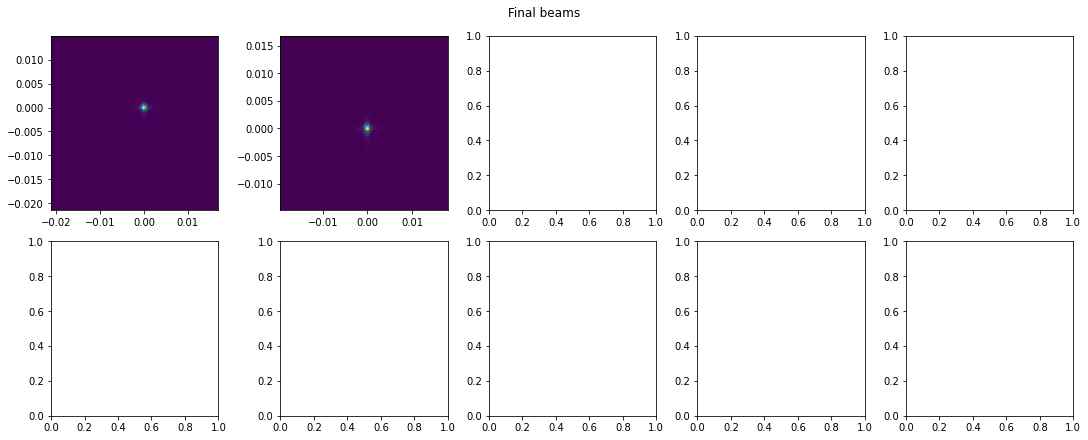

In [54]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/hkb_4_vkb_4_final_beams.png', bbox_inches='tight')

In [1]:
clean_up()

NameError: name 'clean_up' is not defined